# Preliminary Code Blocks

In this section, we provide the C based code blocks that are the primary base for our experiments. There are seven main code blocks,
1. Stochastic: where only the distribution of the income and the returns are known.
2. No Lookahead: where the agent only knows the distributions.
3. Lookahead 1: where we provide the income and returns for the next time step at every time step.
4. Lookahead 2: where we provide the income and returns for the next two time steps at every time step.
5. Lookahead 4: where we provide the income and returns for the next four time steps at every time step.
6. Lookahead 5: where we provide the income and returns for the next five time steps at every time step.
7. No lookahead but given money: in which we provide money instead of lookahead.

## Stochastic

In [ ]:
%%writefile stochastic.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>

//To change init_assets, yrng, yrng2, lookahead
//Initial setup
int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float R[50]; // Real return values
float Y[50]; // Real income values
float S[50]; // Real shock values
float B[50]; // Minimum subsistence values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {1.2,1.5}; // Nominal income range
float yrng2[2] = {0,0}; // Nominal income range
float yshocks[2] = {-0.3,0.3};
float brng[2] = {30,70};
float YM = 7; // Income upper bound
float Ym = 0; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 0;
float granularity = 1;
long long lowvl; // Lowest possible asset values

/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
  float p = 0.5;
  return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            if(constmp>x){
              constmp = x;
            }
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float rtn = R[t-1];
              if(j<n){
              	rtn = (rng[0]+((float)rand() / (float)RAND_MAX)*(rng[1]-rng[0]));
              }
              for(int i=0; i<=n; i++){
                float inc = Y[t-1];
                if(i<n){
              		inc = (yrng[0]+((float)rand() / (float)RAND_MAX)*(yrng[1]-yrng[0]));
              	}
                if(value[t][getListIndex((int)((rtn)*(x-constmp)+(inc)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((rtn)*(x-constmp)+(inc)));
                }
                s+=value[t][getListIndex((long long)((rtn)*(x-constmp)+(inc)), lowvl)];

              }
            }
            float ex = s/(n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
        valon[tl-ts][getListIndex(x, lowvl)] = bst;
        solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[tl-1]){
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		      solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[tl-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[tl-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        if(constmp>x){
          constmp = x;
        }
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[t-1]){
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		      solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[t-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[t-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        if(constmp>x){
          constmp = x;
        }
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[t-1]){
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		      solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[t-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[t-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  FILE *fp3;
  FILE *fp5;
  FILE *fp6;
  FILE *fp7;
  fp3 = fopen("/content/RuntimeData-Online-Normal-Setup-R.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp3,"%f,",R[i]);
  }
  fp5 = fopen("/content/RuntimeData-Online-Normal-Setup-Y.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp5,"%f,",Y[i]);
  }
  fp6 = fopen("/content/RuntimeData-Online-Normal-Setup-B.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp6,"%f,",B[i]);
  }
  fp7 = fopen("/content/RuntimeData-Online-Normal-Setup-S.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp7,"%f,",S[i]);
  }
  fclose(fp3);
  fclose(fp5);
  fclose(fp6);
  fclose(fp7);
  DPStochastic(1, x);
  FILE *fp1;
  fp1 = fopen("/content/RuntimeData-Online-Normal-Stochastic-Value.csv", "w+");
  FILE *fp2;
  fp2 = fopen("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv", "w+");
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
    	fprintf(fp1,"%f,",value[i][j]);
		fprintf(fp2,"%f,",cons[i][j]);
    }
    fprintf(fp1,"\n");
	fprintf(fp2,"\n");
  }
  fclose(fp1);
  fclose(fp2);

  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }

void generateR(void){
    srand(1111); // randomize seed
    for(int i=0;i<T;i++){
      if(get_random()>0.9){
        R[i] = rng[0]+get_random()*(rng[1]-rng[0])+(rng2[0]+get_random()*(rng2[1]-rng2[0])); // Generate a shock value with 0.1 prob.
      }else{
        R[i] = (rng[0]+get_random()*(rng[1]-rng[0]));
      }
    }
}

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}

float basic_expenditure(float income){
    float basic_needs = 0;
    income = 4*income;
    if(income <= 1.2568260226625605){
        basic_needs = 25856/12;
    }else if(income <= 2.1841808609145184){
        basic_needs = 31499/12;
    }else if(income<= 3.1160042501484027){
        basic_needs = 37131/12;
    }else if(income <= 4.237546534052588){
        basic_needs = 43822/12;
    }else if(income <=5.396604512183551){
        basic_needs = 49367/12;
    }else if(income <=6.790213433512611){
        basic_needs = 56720/12;
    }else if(income <=8.564621039595588){
        basic_needs = 66435/12;
    }else if(income <=11.194399946842418){
        basic_needs = 75945/12;
    }else if(income <=16.030104407593548){
        basic_needs = 96913/12;
    }else{
        basic_needs = 145967/12;
    }
    return basic_needs/4000;
}

int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  generateR();
  srand(1111);
  for(int i=0;i<T;i++){
  	if(get_random()>0.6){
    	Y[i] = yrng[0]+get_random()*(yrng[1]-yrng[0]);
      S[i] = ((yshocks[0]+get_random()*(yshocks[1]-yshocks[0])))*Y[i];
      Y[i] = (1+(yshocks[0]+get_random()*(yshocks[1]-yshocks[0])))*Y[i];
    }else{
    	Y[i] = yrng[0]+get_random()*(yrng[1]-yrng[0]);
      S[i] = 0;
    }
  }
  for(int i=0;i<T;i++){
  	B[i] = basic_expenditure(Y[i]);
  }
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}


Writing stochastic.c


## No Lookahead

In [ ]:
%%writefile no-lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 0;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing no-lookahead.c


## Lookahead 1

In [ ]:
%%writefile 1-lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 1;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing 1-lookahead.c


## Lookahead 2

In [ ]:
%%writefile 2-lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 2;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing 2-lookahead.c


## Lookahead 4

In [ ]:
%%writefile 4-lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 4;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing 4-lookahead.c


## Lookahead 5

In [ ]:
%%writefile 5-lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 5;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing 5-lookahead.c


## No lookahead but given money

In [ ]:
%%writefile no-lookahead-money.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13+3.12; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float *S; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 0;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Mon-Int-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  float fr = 2;
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  S = readFileVector("/content/RuntimeData-Online-Normal-Setup-S.csv");
  for(int i=0;i<T;i++){
    if(S[i]<0){
      Y[i]= Y[i]-fr*S[i];
    }
  }
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Writing no-lookahead-money.c


# Experiments

We assign interventions (to a sample of 50 individuals per intervention), as follows:  
**(1) Compensation:** Workers will be compensated for sudden schedule changes and *on-call* shifts. This policy is modeled after the measures approved by the San Francisco Board of Supervisors, which introduced new protections for retail workers in the city, necessitating employers to provide compensation for unpredictable schedules based on factors such as employment type, hourly rate, hours of work. Inspired by this policy, we disburse twice the amount of earnings back when there is a negative shock.

**(2) Mandatory minimum advance notice:** Every worker should be entitled to a mandated minimum lookahead, i.e., they should be aware of their schedule for the upcoming two weeks. This proposition is inspired by the Schedules that Work Act of 2014 (H.R. 5159) presented in Congress, which stipulates that if there are alterations to the schedule and minimum hours, the employer must inform the employee at least two weeks prior to the start point of the new schedule.  Inspired by this policy, we assign workers two weeks and roughly one month (5 weeks) of minimum lookahead, separately.

In [ ]:
assets = [123.76]*50
income_pairs = [[1.7897497548171837,2.187471922554336],[3.0620881452826336,3.7425521775676636],[2.0359497717481716,2.4883830543588767],[2.149178970222942,2.6267742969391517],[0.2950707567488854,0.3606420360264155],[0.45544894075487424,0.5566598164781796],[0.6155891955389176,0.752386794547566],[0.3015610295936314,0.3685745917255495],[4.0484651758589525,4.948124103827609],[1.2519776585705913,1.5301949160307227],[0.8937029709135925,1.0923036311166132],[0.4719012991367961,0.5767682545005286],[0.5712704884543025,0.6982194858885921],[1.4615347594798558,1.7863202615864904],[0.20502359389249522,0.2505843925352719],[1.2496495578871227,1.5273494596398167],[0.04464331368985736,0.054564050065381224],[0.7469190261038875,0.9129010319047515],[0.909508062108863,1.1116209647997215],[1.9185182874186815,2.344855684622833],[1.271705412898719,1.5543066157651013],[0.6867674648579276,0.8393824570485783],[0.8084126878853348,0.9880599518598537],[0.8618550742699028,1.0533784241076591],[3.7881406754366713,4.629949714422598],[3.567151270053588,4.359851552287719],[0.3997982367222133,0.48864228932714965],[1.5024982175476873,1.8363867103360625],[2.23592824847307,2.7328011925781968],[1.6341652178387704,1.9973130440251639],[1.3464022806651856,1.6456027874796713],[0.4014186570579152,0.4906228030707852],[1.4182028036450247,1.7333589822328082],[0.14139199113128537,0.17281243360490436],[2.31499757443004,2.8294414798589376],[0.3129570011513683,0.382503001407228],[1.437805364694359,1.7573176679597722],[0.35015876137069946,0.4279718194530771],[0.3657819637102243,0.4470668445347186],[2.116878810042264,2.5872963233849897],[0.2144032034414818,0.2620483597618111],[2.1722904134911696,2.6550216164892073],[1.5306254347342882,1.870764420230797],[0.7688948022732799,0.9397603138895643],[0.48591093194124474,0.5938911390392991],[1.9441264905289497,2.376154599535383],[1.8705482063437615,2.2862255855312643],[1.9214427871419746,2.3484300731735246],[1.0508537467083476,1.284376801532425],[0.3364175922198475,0.41117705715759145],[1.7604127549072432,2.151615589331075],[0.5198999965156753,0.6354333290747143],[1.5966348487517126,1.95144259291876],[0.24578666893027995,0.3004059286925644],[1.9163724309153052,2.3422329711187064],[2.345038307184717,2.866157931003543],[0.7656701104603666,0.9358190238960036],[0.5708622781555662,0.6977205621901366],[0.9567444429527883,1.169354319164519],[0.9561605217270818,1.1686406376664333],[1.6677372452573078,2.0383455219811544],[1.517925650735411,1.8552424620099468],[2.0644762305132556,2.523248726182868],[0.5765997677804418,0.7047330495094288],[1.8820660569660124,2.300302958514015],[2.656909923803507,3.247334351315398],[0.3552008089618406,0.43413432206447183],[1.0631395628762028,1.2993927990709147],[0.702893772970314,0.8590923891859393],[1.2543546725156465,1.5331001552969015],[2.5514696759488715,3.1184629372708432],[0.001101402338653299,0.0013461584139095879],[0.4572066273891647,0.5588081001423124],[2.2768581468471036,2.7828266239242376],[0.12881371197577102,0.15743898130372014],[0.6135383500531871,0.7498802056205621],[0.5673568110095809,0.6934361023450434],[0.6187366130619837,0.7562336381868691],[2.961462973544694,3.6195658565546256],[0.8955403408710836,1.0945493055091022],[1.186989413736288,1.4507648390110186],[1.3537120339552748,1.6545369303897803],[2.5993328011044223,3.1769623124609607],[0.723978785411966,0.8848629599479585],[0.0062719665074704835,0.007665736842463924],[0.8806392432233598,1.076336852828551],[0.9009363338945812,1.101144408093377],[3.734501606139837,4.56439085194869],[0.30388044191087454,0.37140942900218],[2.0662834303122777,2.5254575259372283],[0.680642885851189,0.8318968604847866],[0.4127371261978462,0.5044564875751454],[0.6783922254418993,0.8291460533178769],[0.2355204753439904,0.2878583587537661],[1.8723809424999047,2.2884655963887726],[1.976873596201234,2.4161788398015083],[0.007555673440729742,0.00923471198311413],[1.236952314390415,1.511830606477174],[2.8461911781368743,3.4786781066117354],[0.44105656484865735,0.5390691348150257]]

In [ ]:
from subprocess import call,run
import glob
import os
import numpy as np
import pandas as pd

def utility_func(cons):
  return np.sqrt(cons)

def getUtility(beta,consumption):
  n = len(consumption)
  utilities = []
  for i in range(n):
    cons_row = consumption.iloc[i]
    utility = [utility_func(cons_row[0])]
    for i in range(1,len(cons_row)):
      util = utility[-1]+(beta**i)*utility_func(cons_row[i])
      utility.append(util)
    utilities.append(utility)
  utilities = np.array(utilities)
  return pd.DataFrame(data=utilities)

In [ ]:
n = len(assets)
data = []
#filt = [3,13,15]
for i in range(n):#filt:
  init_assets = str(assets[i])
  inc1 = str(income_pairs[i][0])
  inc2 = str(income_pairs[i][1])
  print(i)
  call(["gcc","stochastic.c","-o","stochastic.out","-lm"])
  tmp=run(["./stochastic.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","no-lookahead.c","-o","no-lookahead.out","-lm"])
  tmp=run(["./no-lookahead.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","1-lookahead.c","-o","1-lookahead.out","-lm"])
  tmp=run(["./1-lookahead.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","2-lookahead.c","-o","2-lookahead.out","-lm"])
  tmp=run(["./2-lookahead.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","4-lookahead.c","-o","4-lookahead.out","-lm"])
  tmp=run(["./4-lookahead.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","5-lookahead.c","-o","5-lookahead.out","-lm"])
  tmp=run(["./5-lookahead.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  call(["gcc","no-lookahead-money.c","-o","no-lookahead-money.out","-lm"])
  tmp=run(["./no-lookahead-money.out", init_assets,inc1,inc2],capture_output = True)
  print(tmp)

  consumption = pd.read_csv("RuntimeData-Online-Consumption.csv",header=None).dropna(axis=1)
  utility = getUtility(0.95,consumption)
  data.append(utility[utility.columns[-1]].to_numpy())
  for clean_up in glob.glob('/content/*.*'):
          if not clean_up.endswith('.c'):
              os.remove(clean_up)

data = np.array(data)
indexes = ["Lookahead 0","Lookahead 1","Lookahead 2","Lookahead 4","Lookahead 5", "Lookahead 0 with Money"]
final_util = pd.DataFrame(data=data.T,index=indexes)
final_util.to_csv("final_util.csv")

0
CompletedProcess(args=['./stochastic.out', '123.76', '1.7897497548171837', '2.187471922554336'], returncode=0, stdout=b'T-26 and D-1548\nLowest value-0\nt=1, x=123\nt=2, x=0\nt=3, x=0\nt=4, x=0\nt=5, x=0\nt=6, x=0\nt=7, x=0\nt=8, x=0\nt=9, x=0\nt=10, x=0\nt=11, x=0\nt=12, x=0\nt=13, x=0\nt=14, x=0\nt=15, x=0\nt=16, x=0\nt=17, x=0\nt=18, x=0\nt=19, x=0\nt=20, x=0\nt=21, x=0\nt=22, x=0\nt=23, x=0\nt=24, x=0\nt=25, x=0\nt=26, x=0\nt=26, x=1\nt=26, x=2\nt=26, x=3\nt=25, x=1\nt=26, x=4\nt=25, x=2\nt=26, x=5\nt=25, x=3\nt=26, x=6\nt=24, x=1\nt=25, x=4\nt=26, x=7\nt=24, x=2\nt=25, x=5\nt=26, x=8\nt=24, x=3\nt=25, x=6\nt=26, x=9\nt=23, x=1\nt=24, x=4\nt=25, x=7\nt=26, x=10\nt=23, x=2\nt=22, x=1\nt=23, x=3\nt=24, x=5\nt=25, x=8\nt=26, x=11\nt=23, x=4\nt=24, x=6\nt=25, x=9\nt=26, x=12\nt=26, x=13\nt=22, x=2\nt=23, x=5\nt=24, x=7\nt=25, x=10\nt=26, x=14\nt=22, x=3\nt=23, x=6\nt=24, x=8\nt=25, x=11\nt=26, x=15\nt=21, x=1\nt=22, x=4\nt=23, x=7\nt=24, x=9\nt=25, x=12\nt=26, x=16\nt=21, x=2\nt=22, 

In [ ]:
final_util.T.describe()

Lookahead 0  Lookahead 1  Lookahead 2  Lookahead 4  Lookahead 5  \
count    50.000000    50.000000    50.000000    50.000000    50.000000   
mean     21.433784    22.792481    22.911232    24.248814    24.870318   
std       3.011903     2.692919     2.581719     2.583464     2.685152   
min      17.028950    19.118442    18.281095    19.781041    20.628541   
25%      19.032523    20.838283    21.303510    22.695491    23.014203   
50%      20.998603    22.348368    22.609114    23.437085    23.967688   
75%      23.168711    24.131552    24.234868    26.099929    26.110070   
max      30.002336    31.102118    30.789076    32.235764    33.189783   

       Lookahead 0 with Money  
count               50.000000  
mean                21.567918  
std                  3.009142  
min                 17.093021  
25%                 19.146964  
50%                 21.134183  
75%                 23.509767  
max                 29.886014

<Axes: >

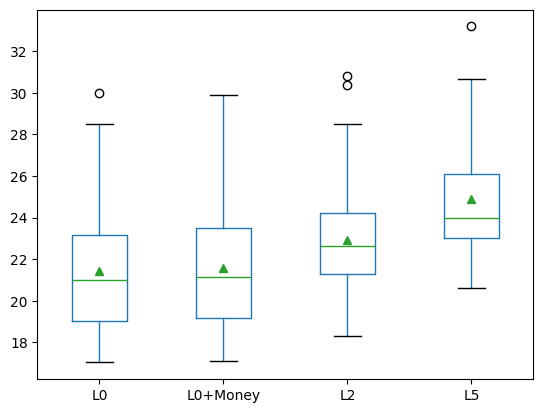

In [ ]:
final_util.index = ["L0","L1","L2","L4","L5","L0+Money"]
final_util.loc[["L0","L0+Money","L2","L5"]].T.boxplot(grid=False,showmeans =True)

Index(['L0', 'L0+Money', 'L2', 'L5'], dtype='object')


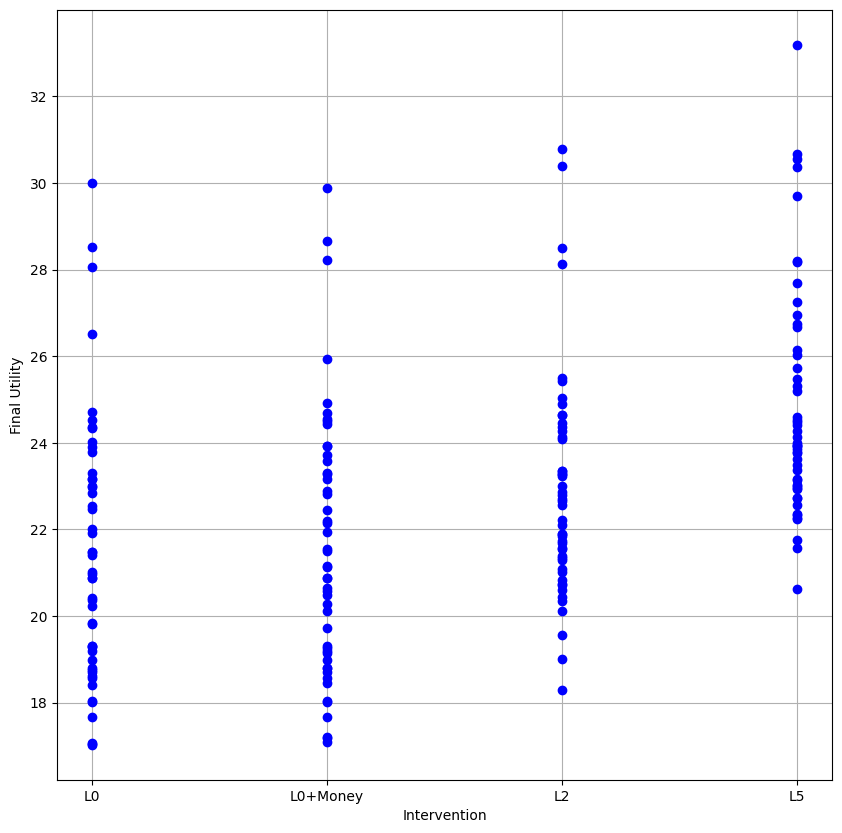

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
df = final_util.loc[["L0","L0+Money","L2","L5"]].T
print(df.columns)
for column in df.columns:
  for d in df[column]:
    plt.plot(column, d, marker='o', linestyle='-', label=column, color='blue')

plt.xlabel("Intervention")
plt.ylabel("Final Utility")
plt.grid(True)
plt.show()